In [25]:
import xarray as xr
import matplotlib.pyplot as plt
from data.utils import load_training_datasets
import os

# %env MLFLOW_TRACKING_URI /scratch/ag7531/mlruns

In [26]:
import xarray as xr
import numpy as np
import math

In [27]:
data_test=False #test with small batch, big batch needs .py to run

In [28]:
param_hires = xr.open_mfdataset('/scratch/gpfs/cz3321/CM2P6/GFDL_CM2_6_grid.nc')

In [29]:
param_hires

<xarray.Dataset>
Dimensions:         (yt_ocean: 2700, xt_ocean: 3600, yu_ocean: 2700,
                     xu_ocean: 3600, st_edges_ocean: 51, st_ocean: 50,
                     sw_edges_ocean: 51, sw_ocean: 50)
Coordinates:
  * st_edges_ocean  (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean        (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_edges_ocean  (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean        (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Data variables: (12/19)
    area_t          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_u          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxu             (yu_ocean, xu_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyu             (yu_ocean, xu_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...              ...
    geolon_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht              (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    hu              (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmu             (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

In [30]:
if data_test==True:
  raw_data = xr.open_zarr('/scratch/cimes/cz3321/MOM6/experiments/double_gyre/postprocess/offline_test/cm2p6/forcing.zarr')
  # raw_data = xr.open_zarr('/scratch/gpfs/cz3321/CM2P6/forcing.zarr') 
  raw_datasets = load_training_datasets(raw_data, 'training_subdomains.yaml')
else:
  # raw_data = xr.open_zarr('/scratch/cimes/cz3321/MOM6/experiments/double_gyre/postprocess/offline_test/cm2p6/forcing.zarr')
  raw_data = xr.open_zarr('/scratch/gpfs/cz3321/CM2P6/forcing.zarr')
  raw_datasets = load_training_datasets(raw_data, 'training_subdomains.yaml')

In [31]:
raw_datasets

[<xarray.Dataset>
 Dimensions:   (time: 7305, yu_ocean: 645, xu_ocean: 900)
 Coordinates:
   * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
   * xu_ocean  (xu_ocean) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
   * yu_ocean  (yu_ocean) float64 -81.02 -80.86 -80.69 ... 84.53 84.7 84.87
 Data variables:
     S_x       (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
     S_y       (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
     usurf     (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
     vsurf     (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
 Attributes:
     filename:   01810101.ocean_minibling_surf_field.nc
     grid_tile:  1
     grid_type:  mosaic
     history:    2014-01-15 17:01:45 -0500: /home/Richard.Slater/ruby/remove_d...
     title:      CM2.6_miniBling]

In [32]:
if data_test==False:
  first_dataset = raw_datasets[0]
  np.random.seed(42)
  random_indices = np.random.choice(first_dataset.time.size, 1000, replace=False)
  random_snapshots = first_dataset.isel(time=random_indices)
  random_snapshots

In [33]:
if data_test==False:
  low_rez = random_snapshots
else:
  low_rez = raw_datasets[0]
u = low_rez['usurf']
v = low_rez['vsurf']
# u = prog['u'].fillna(0)

In [34]:
low_rez.nbytes / 1e9

9.28802036

In [35]:
import torch
import importlib
from torch.nn import Parameter
batch_norm = 1
#load the neural network
def load_model_cls(model_module_name: str, model_cls_name: str):
    try:
        module = importlib.import_module(model_module_name)
        model_cls = getattr(module, model_cls_name)
    except ModuleNotFoundError as e:
        raise type(e)('Could not retrieve the module in which the trained model \
                      is defined: ' + str(e))
    except AttributeError as e:
        raise type(e)('Could not retrieve the model\'s class. ' + str(e))
    return model_cls
def load_paper_net(device: str = 'gpu',file_name='trained_model_global_BC_RP2'):
    """
        Load the neural network from the paper
    """
    print('In load_paper_net()')
    model_module_name = 'models.models1'
    model_cls_name = 'FullyCNN_BC'
    model_cls = load_model_cls(model_module_name, model_cls_name)
    print('After load_model_cls()')
    net = model_cls(2,4,batch_norm=batch_norm)
    
    # final_transform= '/scratch/cimes/cz3321/MOM6/MOM6-examples/src/MOM6/config_src/external/ML_Forpy/Forpy_CNN_GZ21/final_transformation_04292023.pth'
    # print('After net')
    # if device == 'cpu':
    #     transformation = torch.load(final_transform)
    #     print('After torch.load()')
    # else:
    #     transformation = pickle_artifact(MODEL_RUN_ID, 'models/transformation')
    # net.final_transformation = transformation
    print('After transformation')
    # Load parameters of pre-trained model
    print('After mlflow.tracking.MlflowClient()')
    
    
    # ----------------- CHANGE THIS PATH TO TRAINED MODEL ----------------- #
    model_file = '/scratch/cimes/cz3321/MOM6/MOM6-examples/src/MOM6/config_src/external/ML_Forpy/Forpy_CNN_GZ21/'+file_name+'.pth'
    # ---------------------------------------------------- #
    
    
    print('Loading final transformation')
    model_module_name = 'models.transforms'
    model_cls_name1 = 'SoftPlusTransform'
    model_cls = load_model_cls(model_module_name, model_cls_name1)
    model_cls_name2 = 'PrecisionTransform'
    model_cls1 = load_model_cls(model_module_name, model_cls_name2)
    transform = model_cls.__new__(model_cls,)
    model_cls1.__init__(transform,)
    state_dict = torch.load(model_file, map_location=torch.device('cpu'))
    # print('file:',state_dict.keys())
    # print('net:',net.state_dict().keys())
    transform._min_value = Parameter(state_dict.pop('final_transformation._min_value'))
    transform.indices = slice(2,4)
    print('After download_artifacts()')
    #change the key name->
    print(model_cls_name)
    #<-
    net.load_state_dict(state_dict)
    net.final_transformation = transform
    print(net)
    return net
net1 = load_paper_net('cpu',file_name='trained_model_global_BC_6824')
net1.eval()
net2 = load_paper_net('cpu',file_name='trained_model_global_BC_0P')
net2.eval()
net3 = load_paper_net('cpu',file_name='trained_model_global_BC_RP')
net3.eval()

In load_paper_net()
After load_model_cls()
After transformation
After mlflow.tracking.MlflowClient()
Loading final transformation
After download_artifacts()
FullyCNN_BC
FullyCNN_BC(
  (conv1): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, 

FullyCNN_BC(
  (conv1): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(32, 32, kernel_size

In [36]:
device = torch.device('cpu')
from train.losses import HeteroskedasticGaussianLossV2

In [37]:
criterion = HeteroskedasticGaussianLossV2(n_target_channels=2)

In [38]:
from testing.utils_bc import (create_large_test_dataset, create_test_dataset)
from torch.utils.data import DataLoader

In [39]:
from data.datasets import (RawDataFromXrDataset, DatasetTransformer,
                           Subset_, DatasetWithTransform, ComposeTransforms,
                           MultipleTimeIndices, DatasetPartitioner)
if data_test==True:
  low_rez = low_rez.fillna(0)
  # low_rez = low_rez.isel(time=slice(0, 10))
  dataset = RawDataFromXrDataset(low_rez * 10.)
  dataset.index = 'time'
  dataset.add_input('usurf')
  dataset.add_input('vsurf')
  dataset.add_landmask_input()
  dataset.add_output('S_x')
  dataset.add_output('S_y')
  features_transform_ = ComposeTransforms()
  targets_transform_ = ComposeTransforms()
  transform = DatasetTransformer(features_transform_, targets_transform_)
  transform.fit(dataset)
  dataset = DatasetWithTransform(dataset, transform)
  test1 = create_large_test_dataset(net1.to(device=device), criterion, [dataset, ], [DataLoader(dataset)], device,mask=False, replicate=False)
  test1 = test1.rename(dict(longitude='xu_ocean', latitude='yu_ocean'))
  test2 = create_large_test_dataset(net2.to(device=device), criterion, [dataset, ], [DataLoader(dataset)], device,mask=True, replicate=False)
  test2 = test2.rename(dict(longitude='xu_ocean', latitude='yu_ocean'))
  test3 = create_large_test_dataset(net3.to(device=device), criterion, [dataset, ], [DataLoader(dataset)], device,mask=True, replicate=True)
  test3 = test3.rename(dict(longitude='xu_ocean', latitude='yu_ocean'))
else:
  low_rez = low_rez.fillna(0)
  dataset = RawDataFromXrDataset(low_rez * 10.)
  dataset.add_landmask_input()

In [41]:
if data_test==True:
  from dask.diagnostics import ProgressBar
  with ProgressBar():
      test1 = test1.compute()
      test2 = test2.compute()
      test3 = test3.compute()
else:
   test1 = xr.open_dataset('test_global_nobc_train&implement.nc')
   test2 = xr.open_dataset('test_global_0pad_train&implement.nc')
   test3 = xr.open_dataset('test_global_rpad_train&implement.nc')

In [42]:
def R2_snapshot(prediction, target):
  # return np.maximum(float(1 - (np.nanmean((target-prediction)**2)) / np.nanmean((target**2))),0)
  return np.maximum(1 - ((target-prediction)**2) / (target**2),0)
def MSE_snapshot(prediction, target):
  return (target-prediction)**2
def XSX_snapshot(prediction, target, velocity):
  return np.abs(velocity*target-velocity*prediction)

In [43]:
def sx_error_plt(test,var='S_x'):
    fig, ax = plt.subplots(3, 1, figsize=(12,10))
    plt.rcParams.update({'font.size': 12})
    ax = ax.reshape(-1)
    S_test = test.isel(time=-1)['S_x']*(1e-7)
    S_true = low_rez.isel(time=-1)['S_x']
    error = S_true-S_test
    mask=dataset.isel(time=0)['landmask'].values
    maskn=np.where(mask == 0, torch.tensor(float('nan')), mask)
    R2_local = round(np.nanmean(R2_snapshot(S_test.values*maskn, S_true.values*maskn)),3)
    xq = test['xu_ocean']
    yq = test['yu_ocean']
    
    p = ax[0].imshow(S_true, origin='lower',
        extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
        cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
    # ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    if var=='S_x':
        ax[0].set_title('(a) $S_{x}^{(mean)}$: true forcing')
    else:
        ax[0].set_title('(a) $S_{y}^{(mean)}$: true forcing')
    
    p = ax[1].imshow(S_test, origin='lower',
        extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
        cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
    # ax[1].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    if var=='S_x':
        ax[1].set_title('(b) $S_{x}^{(mean)}$: offline prediction')
    else:
        ax[1].set_title('(b) $S_{y}^{(mean)}$: offline prediction')
    
    
    p = ax[2].imshow(error, origin='lower',
        extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
        cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
    ax[2].set_xlabel('Longitude')
    ax[2].set_ylabel('Latitude')
    ax[2].set_title('(c) Error map'+f'$ R^2$(snapshot)={R2_local}')
    
    fig.colorbar(p, ax=ax, label='Subgrid forcing: $ms^{-2}$')
        # plt.savefig('../Paper_figures/figureB_1_1.png', dpi=300, bbox_inches="tight")
    
    # test.isel(time=-10)['S_x'].plot(vmin=-1, vmax=1, cmap='bwr')

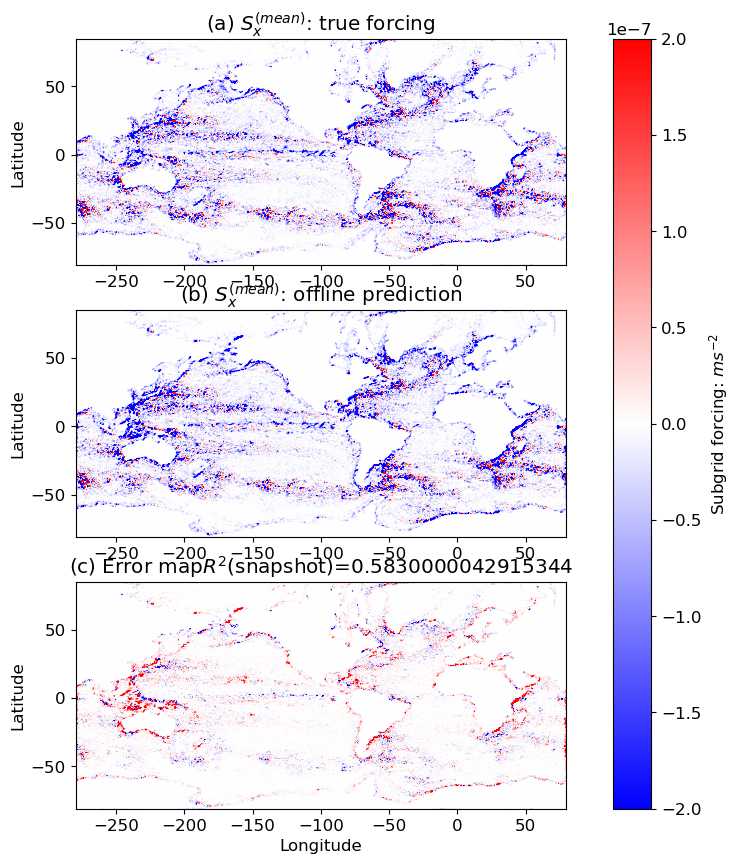

In [44]:
sx_error_plt(test1)

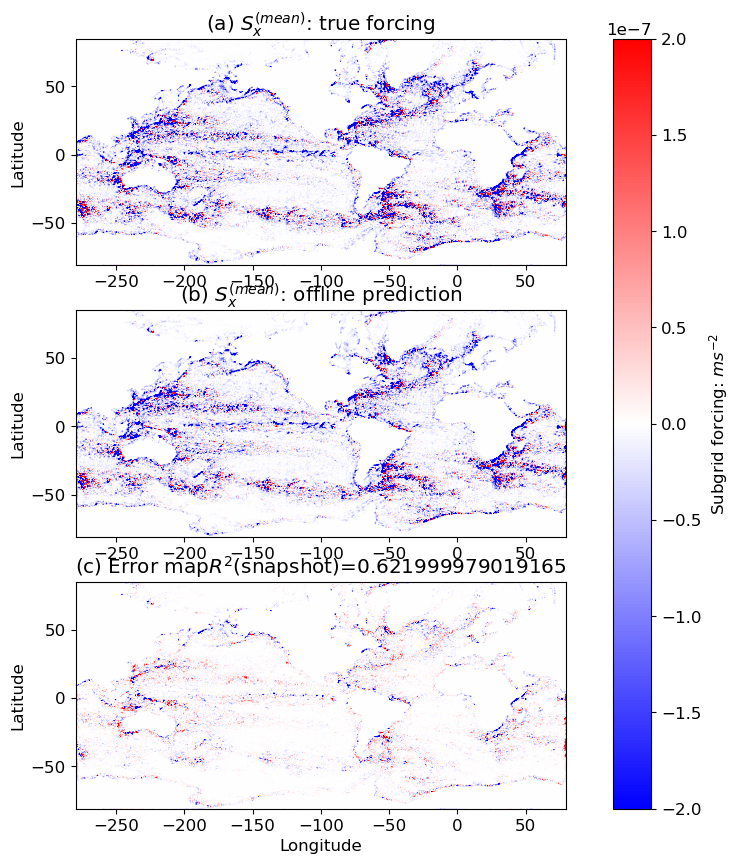

In [45]:
sx_error_plt(test2)

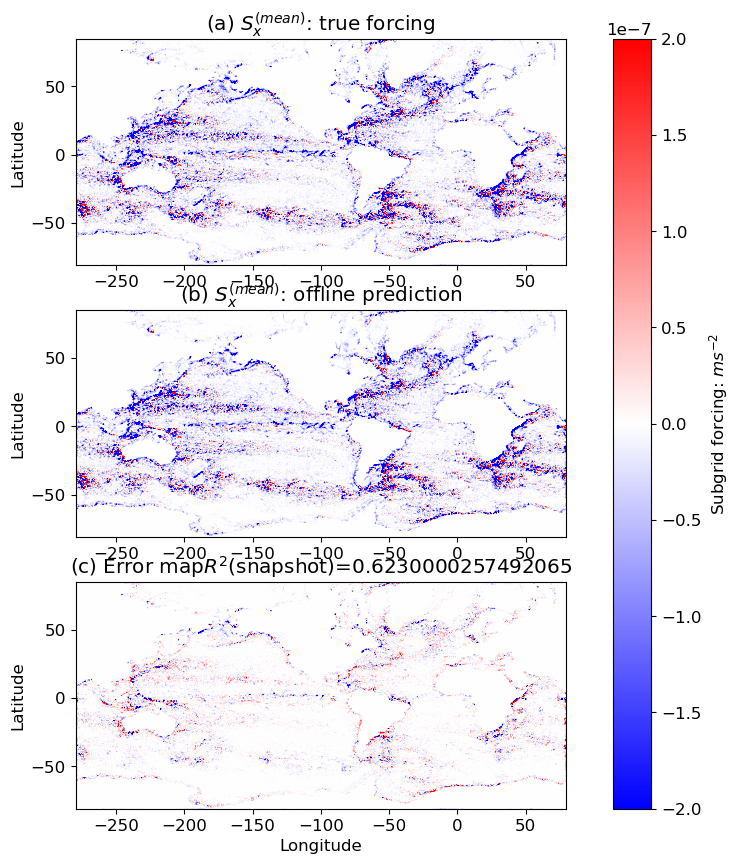

In [46]:
sx_error_plt(test3)

In [47]:
def xsx_error_plt(test):
    fig, ax = plt.subplots(2, 1, figsize=(12,10))
    plt.rcParams.update({'font.size': 12})
    ax = ax.reshape(-1)
    S_test = test.isel(time=-1)['S_x']*(1e-7)
    S_true = low_rez.isel(time=-1)['S_x']
    X_coarse = u.isel(time=-1)
    mask=dataset.isel(time=0)['landmask'].values
    maskn=np.where(mask == 0, torch.tensor(float('nan')), mask)
    
    xq = test['xu_ocean']
    yq = test['yu_ocean']
    
    MSE = MSE_snapshot(S_test.values*maskn, S_true.values*maskn)
    MSE_local = float(np.nanmean(MSE))
    XSX = XSX_snapshot(S_test.values*maskn, S_true.values*maskn, X_coarse.values*maskn)
    XSX_local = float(np.nanmean(XSX))
    
    p = ax[0].imshow(MSE, origin='lower',
        extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
        vmin=0, vmax = 1*1e-13)
    # ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[0].set_title('(a) $S_{x}^{(mean)}$: true forcing')
    fig.colorbar(p, ax=ax[0], label='Subgrid forcing: $ms^{-2}$')
    
    ax[0].set_ylabel('Latitude')
    ax[0].set_title('(a) MSE map:'+f'   $MSE$(snapshot)={MSE_local}')
    
    p = ax[1].imshow(XSX, origin='lower',
        extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
        vmin=0, vmax = 1*1e-8)
    # ax[0].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    ax[1].set_title('(a) $S_{x}^{(mean)}$: true forcing')
    fig.colorbar(p, ax=ax[1], label='Subgrid forcing: $ms^{-2}$')
    
    ax[1].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    ax[1].set_title('(b) XSX map:'+f'   $XSX$(snapshot)={XSX_local}')
def xsx_error_timemean(test,test_name='test'):
    S_test = test['S_x']*(1e-7)
    S_true = low_rez['S_x']
    X_coarse = u
    mask=dataset.isel(time=0)['landmask'].values
    maskn=np.where(mask == 0, torch.tensor(float('nan')), mask)

    MSE = MSE_snapshot(S_test.values*maskn, S_true.values*maskn)
    MSE_timemean = float(np.nanmean(MSE))
    XSX = XSX_snapshot(S_test.values*maskn, S_true.values*maskn, X_coarse.values*maskn)
    XSX_timemean = float(np.nanmean(XSX))
    print('MSE over time for '+test_name+':',MSE_timemean, ';  XSX over time for '+test_name+':',XSX_timemean)

In [48]:
xsx_error_timemean(test1,test_name='test1')
xsx_error_timemean(test2,test_name='test2')
xsx_error_timemean(test3,test_name='test3')

MSE over time for test1: 3.352547596089869e-14 ;  XSX over time for test1: 5.782831102862929e-09
MSE over time for test2: 2.25433820916221e-14 ;  XSX over time for test2: 4.187656887921776e-09
MSE over time for test3: 1.3280176417373394e-14 ;  XSX over time for test3: 4.135310760489119e-09


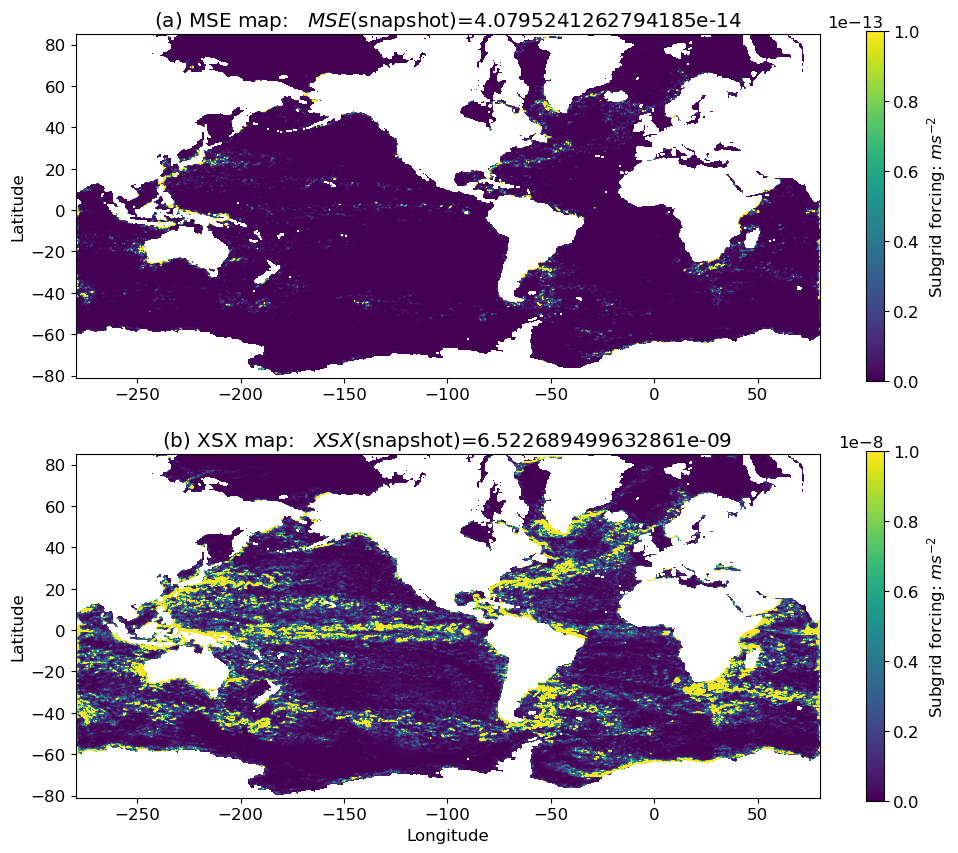

In [49]:
xsx_error_plt(test1)

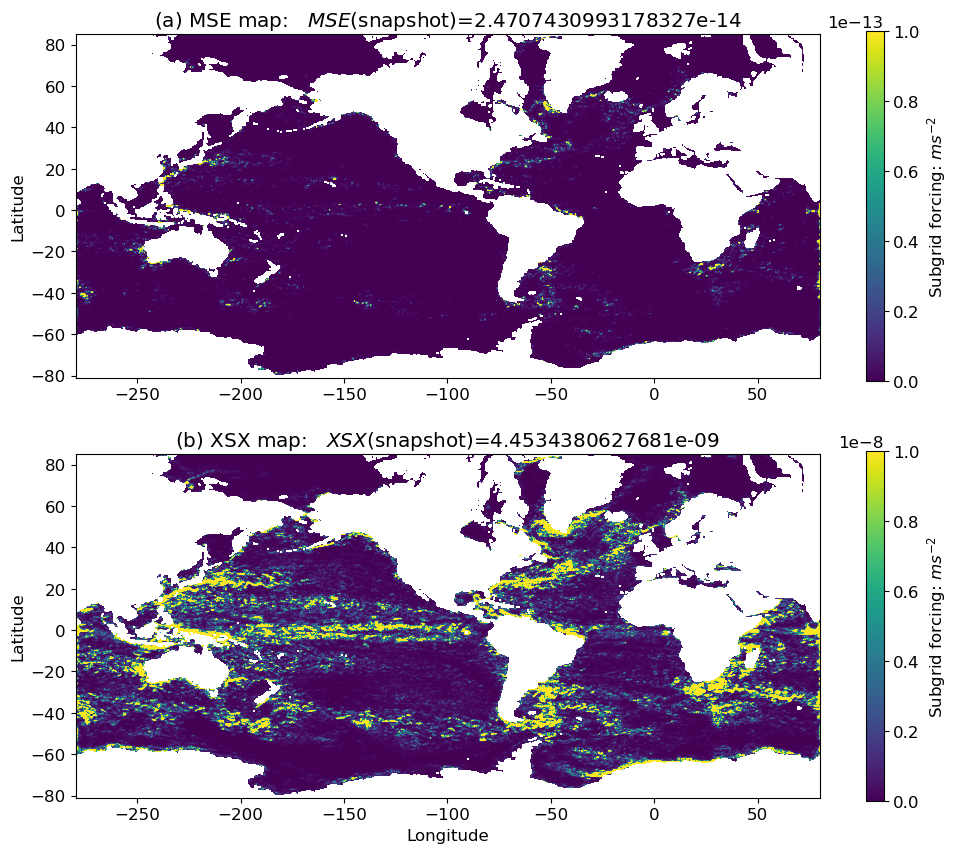

In [50]:
xsx_error_plt(test2)

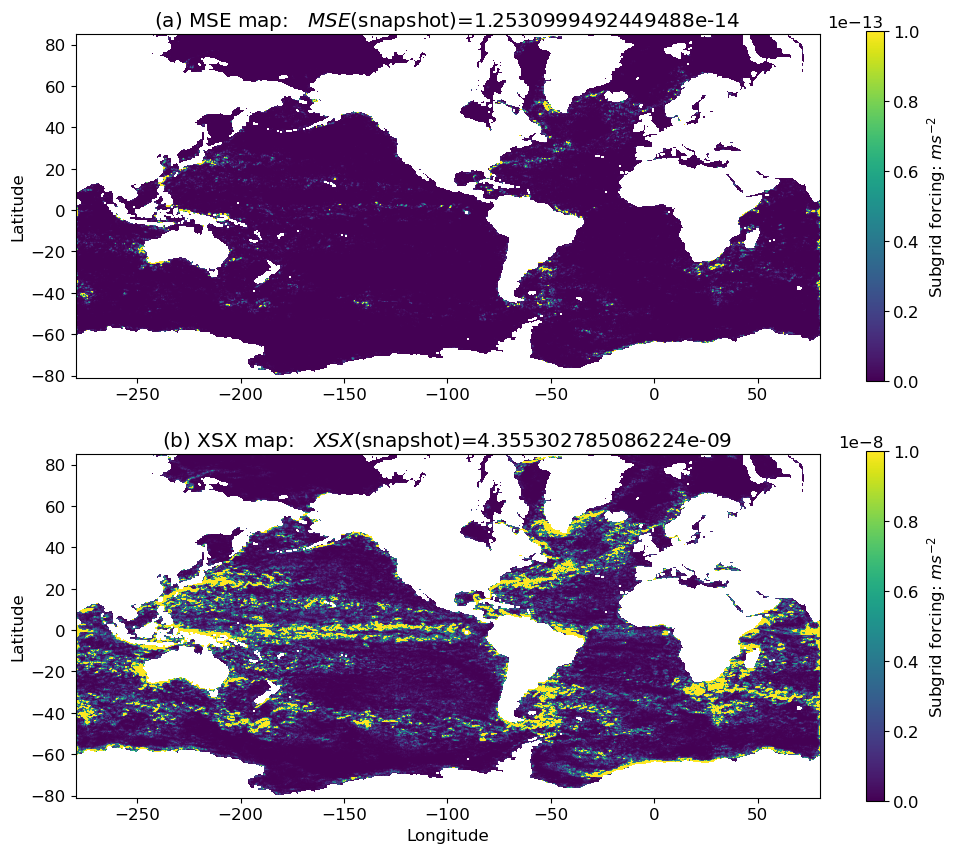

In [51]:
xsx_error_plt(test3)

In [52]:
def R2(test, xlim=None, ylim=None):
    mask=dataset.isel(time=0)['landmask'].values
    maskn=np.where(mask == 0, torch.tensor(float('nan')), mask)
    # mse = dict()
    # variance = dict()
    r_squared = dict()
    # correlation = dict()
    # for var in ['S_x', 'S_y']:
        # mse[var] = ((test[var] - low_rez[var]*1e7)**2).mean(dim='time')
        # variance[var] = ((low_rez[var]*1e7)**2).mean(dim='time')
        # r_squared[var] = 1 - mse[var] / variance[var]
        # correlation[var] = xr.corr(test[var], low_rez[var]*1e7, dim='time')
    from matplotlib.patches import Arrow, Circle
    fig = plt.figure(figsize=(12,5))
    plt.rcParams.update({'font.size': 16})
    extent = (low_rez['xu_ocean'].min(), low_rez['xu_ocean'].max(), low_rez['yu_ocean'].min(), low_rez['yu_ocean'].max())
    for i, var in enumerate(['S_x', 'S_y']):
        predict = test[var]*maskn
        target = low_rez[var]*1e7*maskn
        mse = ((target - predict)**2).mean(dim='time')
        variable = (target**2).mean(dim='time')
        R2_ss = np.maximum((1 - mse / variable),0)
        # R2_ss = (1 - mse / variable)
        plt.subplot(1, 2, i + 1)
        im = plt.imshow(R2_ss, vmin=0., vmax=1,
                       origin='lower', extent=extent, aspect="auto")
        if xlim is not None:
            plt.xlim(xlim[0],xlim[1])
        if ylim is not None:
            plt.ylim(ylim[0],ylim[1])
        
        if i == 0:
            plt.ylabel('Latitude')
            patches = [Circle((11, 40), radius=0.4, color='white'),
                         Circle((18, 40), radius=0.4, color='green'),]
            for patch in patches:
                  im.axes.add_patch(patch)
            # values = r_squared[var].values
            # values = np.where(values < 0, 0, values)
            # R2_global = round(float(np.nanmean(values*maskn)),3)
            # R2_global = round(R2_snapshot(test[var].values*maskn, low_rez[var].values*1e7*maskn),3)
            R2_global = round(float(np.nanmean(R2_ss)),3)
            plt.title('(a) $R^2$ for $S_{x}^{(mean)}$;'+f'$R^2$(global)={R2_global}')
        elif i == 1:
            patches = [Circle((11, 40), radius=0.4, color='white'),
                         Circle((18, 40), radius=0.4, color='green'),]
            for patch in patches:
                  im.axes.add_patch(patch)
            # values = r_squared[var].values
            # values = np.where(values < 0, 0, values)
            # R2_global = round(float(np.nanmean(values*maskn)),3)
            # R2_global = round(R2_snapshot(test[var].values*maskn, low_rez[var].values*1e7*maskn),3)
            R2_global = round(float(np.nanmean(R2_ss)),3)
            plt.title('(b) $R^2$ for $S_{y}^{(mean)}$;'+f'$R^2$(global)={R2_global}')
        plt.xlabel('Longitude')
    
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.1, 0.025, 0.8])
    cbar = fig.colorbar(im, cax=cbar_ax, label=r'$R^2$')

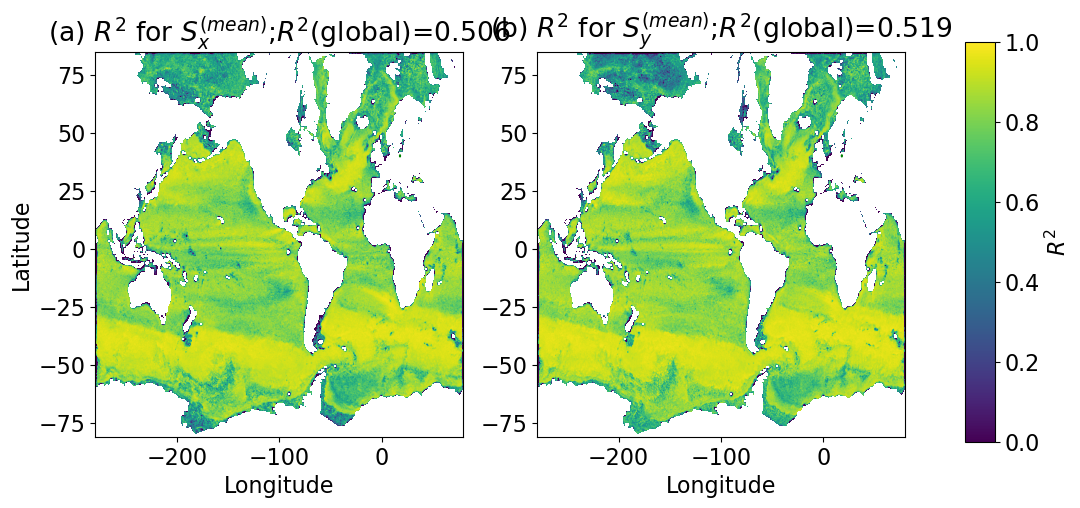

In [53]:
R2(test1)

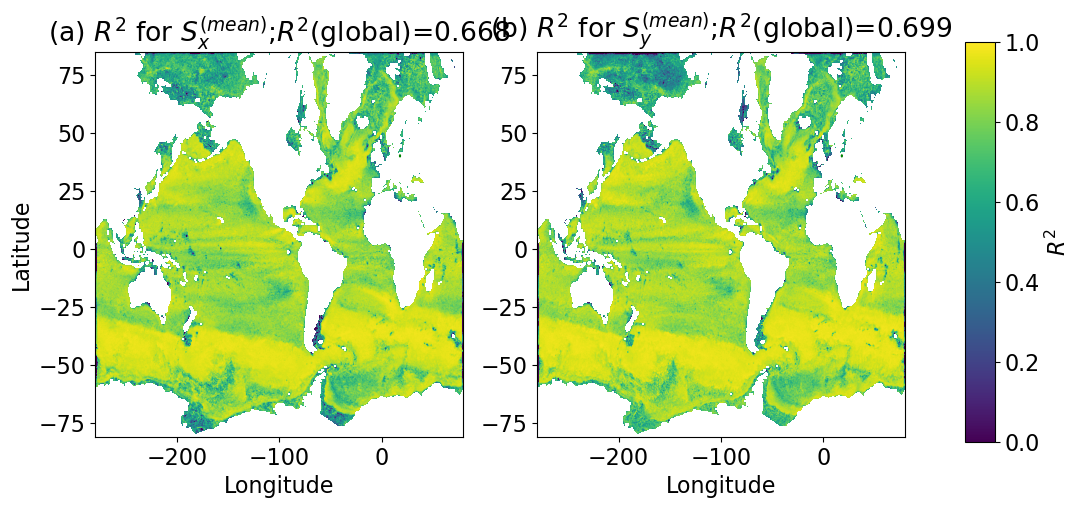

In [54]:
R2(test2)

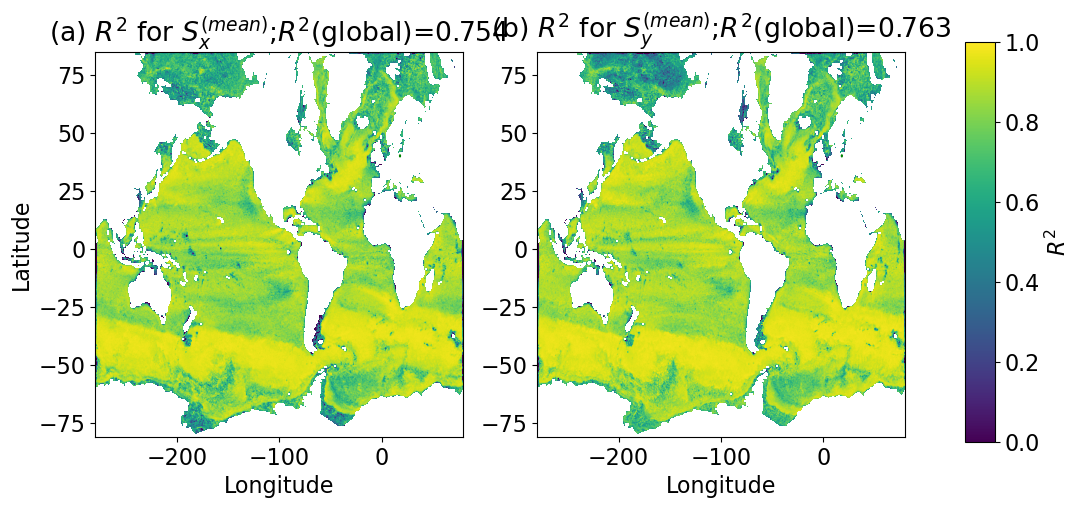

In [55]:
R2(test3)

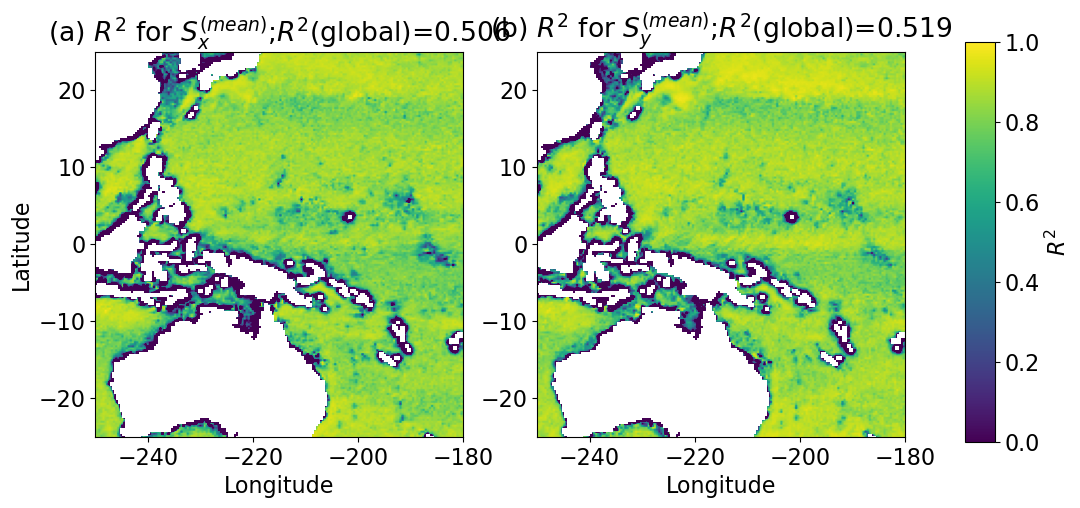

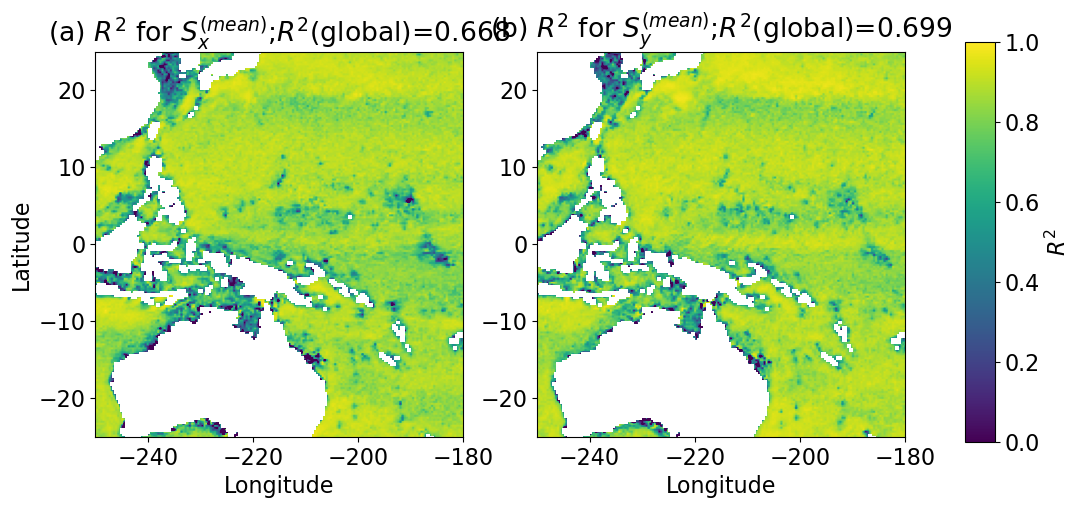

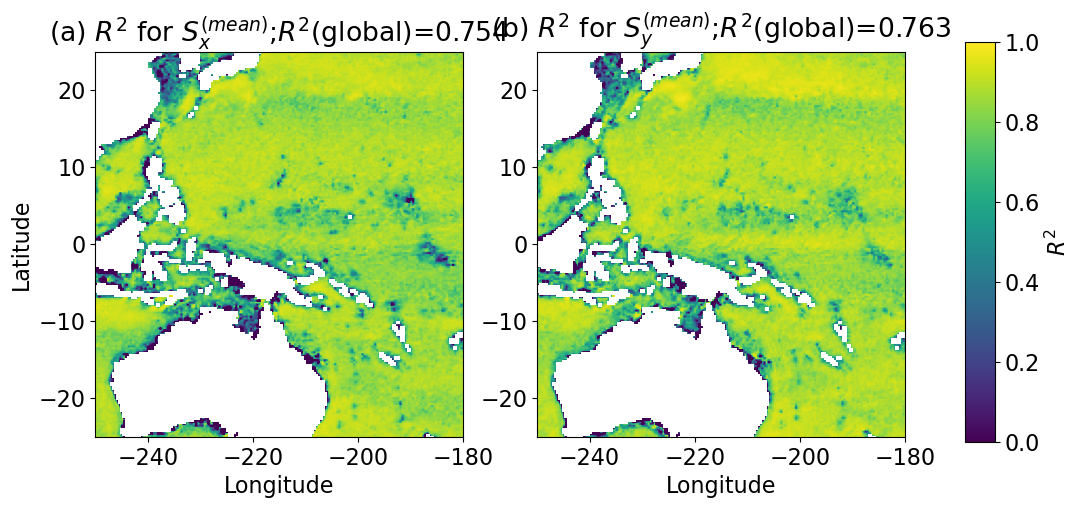

In [56]:
R2(test1,xlim=[-250,-180],ylim=[-25,25])
R2(test2,xlim=[-250,-180],ylim=[-25,25])
R2(test3,xlim=[-250,-180],ylim=[-25,25])